## Outlier detection

Implement outlier remove as a step and check differences in results

In [1]:
import pandas as pd
train_df = pd.read_csv('data/train.csv')

In [10]:
train_numerical =  train_df.select_dtypes(exclude=['object'])
train_numerical = train_numerical.drop('Id', axis=1)

In [11]:
train_numerical.columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

First some visual examinations

In [23]:
import seaborn
seaborn.set()

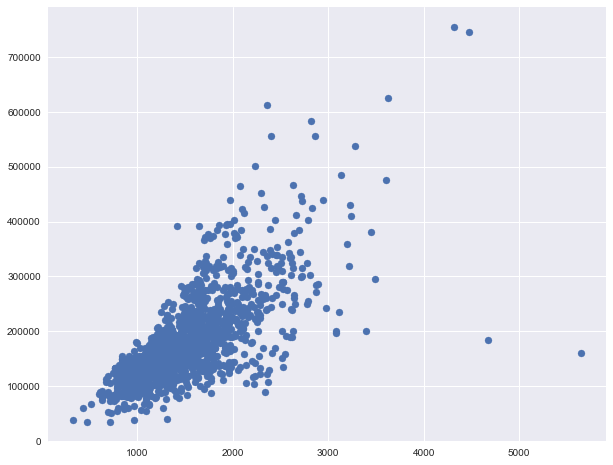

In [25]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, figsize=(10,8))
ax.scatter(train_numerical['GrLivArea'], train_numerical['SalePrice'])
plt.show()

We could have outliers there on the right, but this is not yet confirmed. Meaning there could be a reason for this. One reason could be the age of the houses.

<IPython.core.display.Javascript object>


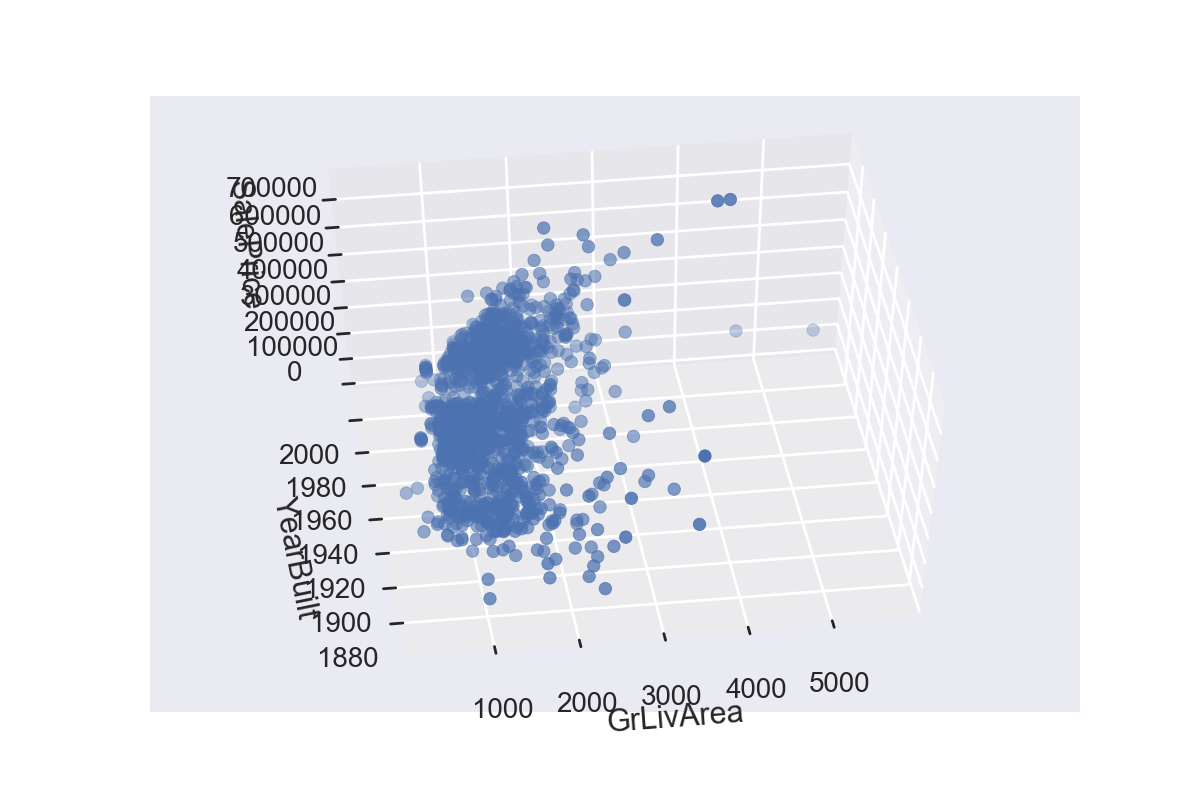

In [36]:
%matplotlib notebook

from mpl_toolkits import mplot3d

plt.figure(figsize=(6, 4))
ax = plt.axes(projection='3d')
ax.scatter3D(train_numerical['GrLivArea'], train_numerical['YearBuilt'], train_numerical['SalePrice'])
ax.set_xlabel('GrLivArea')
ax.set_ylabel('YearBuilt')
ax.set_zlabel('SalePrice')

plt.show()

In [46]:
outliers = train_numerical.loc[(train_numerical.GrLivArea > 4000) & (train_numerical.SalePrice < 200000), :]

In [76]:
outliers

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
523,60,130.0,40094,10,5,2007,2008,762.0,2260,0,...,208,406,0,0,0,0,0,10,2007,184750
1298,60,313.0,63887,10,5,2008,2008,796.0,5644,0,...,214,292,0,0,0,480,0,1,2008,160000


In [78]:
train_df.loc[(train_df.Id == 523) |(train_df.Id == 1298) , :]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
522,523,50,RM,50.0,5000,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,10,2006,WD,Normal,159000
1297,1298,180,RM,35.0,3675,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2006,New,Partial,140000


In [71]:
outliers.index

Int64Index([523, 1298], dtype='int64')

In [49]:
train_numerical = train_numerical.drop(train_numerical.loc[(train_numerical.GrLivArea > 4000) \
                                                           & (train_numerical.SalePrice < 200000), :].index)

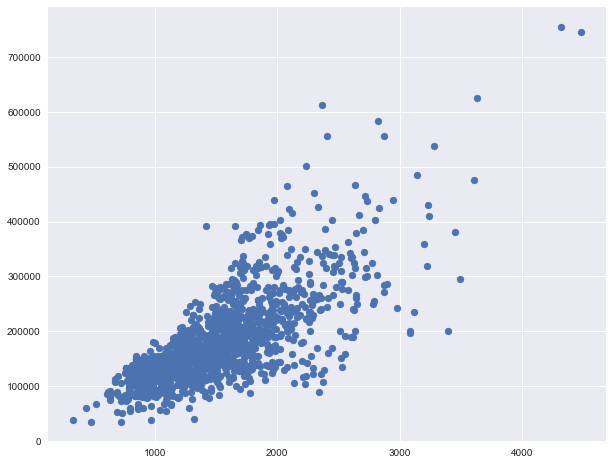

In [52]:
%matplotlib inline

import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, figsize=(10,8))
ax.scatter(train_numerical['GrLivArea'], train_numerical['SalePrice'])
plt.show()

We try to use isolation forest to examine outliers

http://sdsawtelle.github.io/blog/output/week9-anomaly-andrew-ng-machine-learning-with-python.html

In [55]:
# How many null rows in each column
null_columns = train_numerical.columns[train_numerical.isnull().any()]
train_numerical[null_columns].isnull().sum()

LotFrontage    259
MasVnrArea       8
GarageYrBlt     81
dtype: int64

In [64]:
train_numerical = train_numerical.drop(['LotFrontage','MasVnrArea','GarageYrBlt'], axis=1)

In [65]:
null_columns = train_numerical.columns[train_numerical.isnull().any()]
train_numerical[null_columns].isnull().sum()

Series([], dtype: float64)

In [66]:
import numpy as np
from sklearn.ensemble import IsolationForest

rng = np.random.RandomState(42)

# The prediction returns 1 if sample point is inlier. If outlier prediction returns -1
rng = np.random.RandomState(42)
clf_all_features = IsolationForest(max_samples=100, random_state=rng)
clf_all_features.fit(train_numerical)

# Predict if a particular sample is an outlier using all features for higher dimensional data set.
y_pred_train = clf_all_features.predict(train_numerical)

In [69]:
y_pred_train[y_pred_train == 0]

array([], dtype=int32)

No result with isolationforest. We can try pca component anaylsis. Therefore we first do this.